In [1]:
from argoverse.map_representation.map_api import ArgoverseMap

am = ArgoverseMap()

In [23]:
import math
import numpy as np
from shapely.geometry import LineString

def draw(agent,others,rotation,translation_x, translation_y, city_name,TE,plt, time_length = None):
    def denormalization(AGENT,arr, angle, translation_x, translation_y):

        theta = (angle)/180*math.pi
        c, s = np.cos(theta), np.sin(theta)
        R = np.array(((c, -s), (s, c)))

        #rotate
        arr = np.array([R.dot(arr[...,:2][i].reshape((2,1))).flatten() for i in range(len(arr[...,:2]))])

        #translate
        arr[...,0] += translation_x
        arr[...,1] += translation_y
        return arr

    if time_length == None:
        time_length = len(agent[...,0])
    
    # Recalculate angle
    angle_ans = -rotation

    xmin, xmax, ymin, ymax = [9999], [-9999] , [9999] , [-9999]
#     print(len(TE), len(others))
    for i,p in enumerate(others):
        if not math.isnan(TE[i]):
            
            others_length = min(time_length, len(p)) # 간혹 agent를 제외한 vehicle들의 time_step은 50이 안되는 경우가 있으므로 추가해준 코드

            p = denormalization(agent,np.array(p), angle_ans, -translation_x, -translation_y)
            plt.plot(p[:others_length,0], p[:others_length,1], color = 'black')

            # 4초 이하의 vehicle들은 하얀 원으로 표기하겠다.
            if len(p[...,0]) > 40: 
                plt.scatter(p[:others_length,0][-1], p[:others_length,1][-1], color = 'black')
            else:
                plt.scatter(p[:others_length,0][-1], p[:others_length,1][-1], color = 'white')

            plt.scatter(p[:others_length,0][-1], p[:others_length,1][-1], color = "red", alpha = TE[i] + 0.1, s=200, zorder = -1) # TE 값이 클수록 진해짐
            xmin, xmax = min(np.append(xmin, p[...,0])), max(np.append(xmax, p[...,0]))
            ymin, ymax = min(np.append(ymin, p[...,1])), max(np.append(ymax, p[...,1]))
        
    agent =  denormalization(agent,np.array(agent), angle_ans, -translation_x, -translation_y)
    plt.plot(agent[:time_length,0], agent[:time_length,1], color = 'blue',linewidth=2)
    plt.scatter(agent[:time_length,0][-1], agent[:time_length,1][-1], color = 'blue',s=100)
    xmin, xmax = min(np.append(xmin, agent[...,0])), max(np.append(xmax, agent[...,0]))
    ymin, ymax = min(np.append(ymin, agent[...,1])), max(np.append(ymax, agent[...,1]))
    
    local_lane_polygons = am.find_local_lane_polygons([xmin, xmax, ymin, ymax], city_name)
    for l in local_lane_polygons:
        plt.plot(l[...,0],l[...,1], linewidth='0.5', color='gray')
    return plt


In [24]:
import numpy as np
def normalize_TE(arr):
    arr = np.array(arr)
    min_arr = min(arr.flatten())
    max_arr = max(arr.flatten())
    mul = 0.89 / (max_arr - min_arr)
    add = -1 *min_arr
    norm_arr = (arr + add) * mul
    return norm_arr[...,0],norm_arr[...,1] , round(min_arr,5), round(max_arr,5)



파란 원 : AGENT

까만 원 : OTHERS(AGENT를 제외한 vehicle)

하얀 원 : OTHERS 중 길이가 많이 짧은 것들(4초 이하)

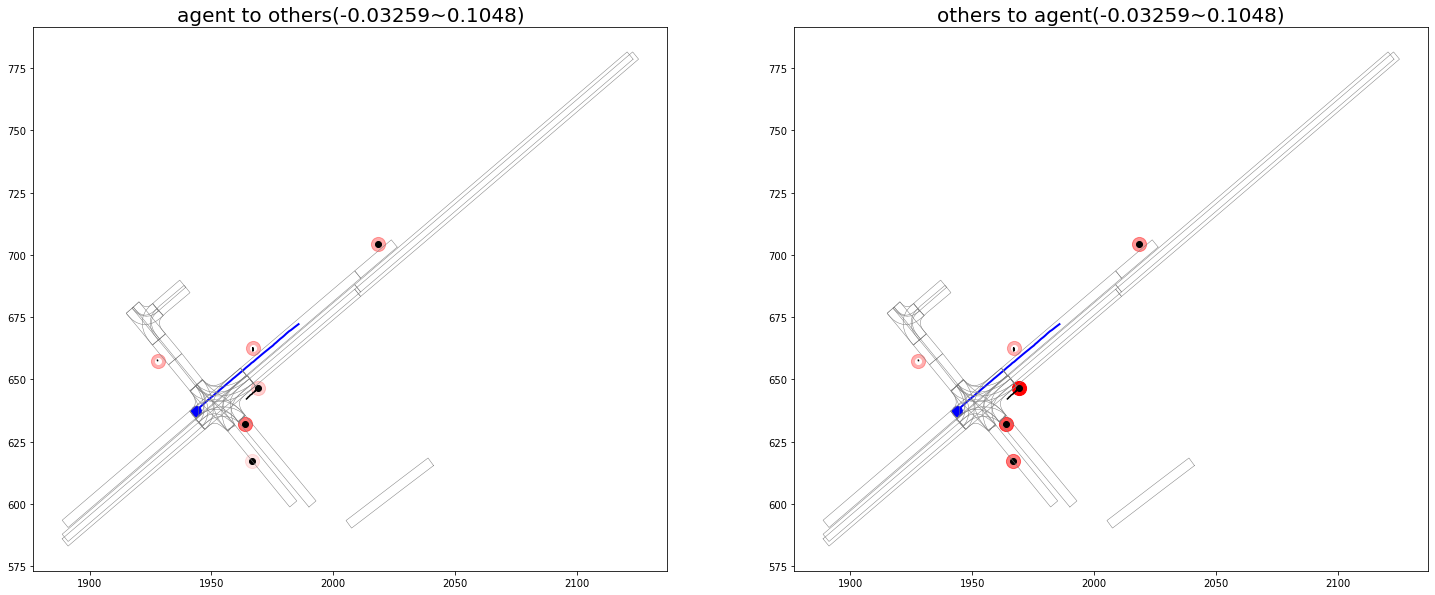

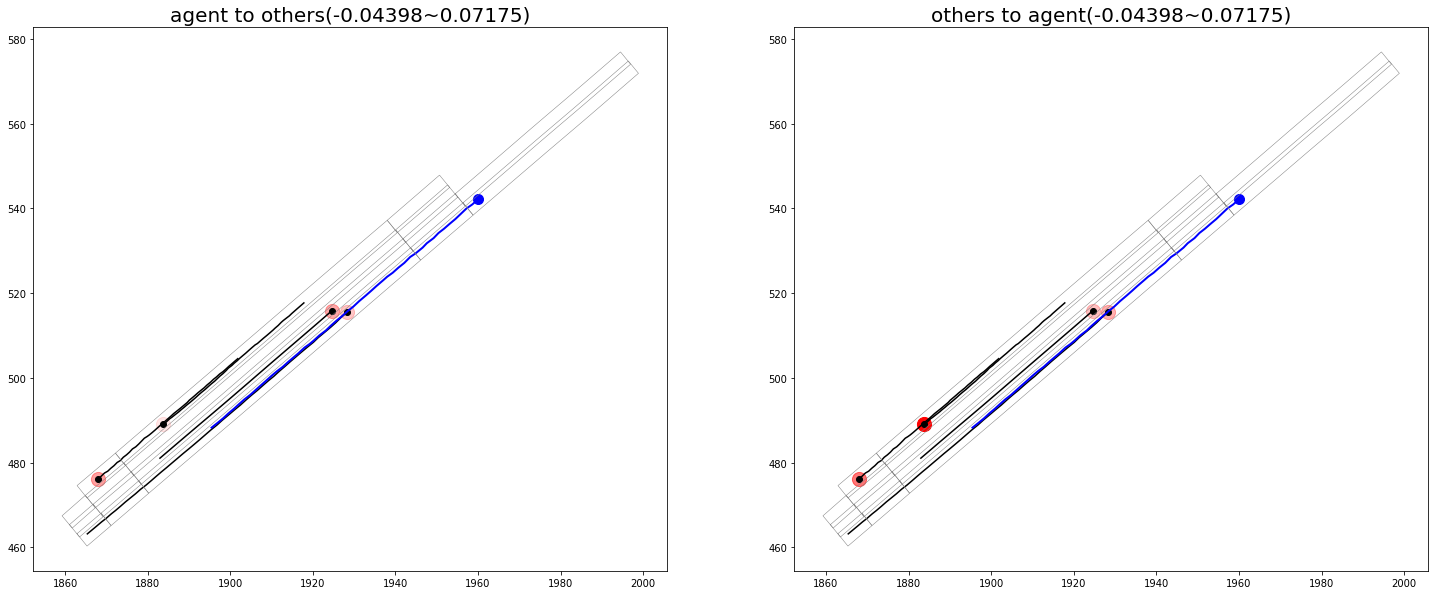

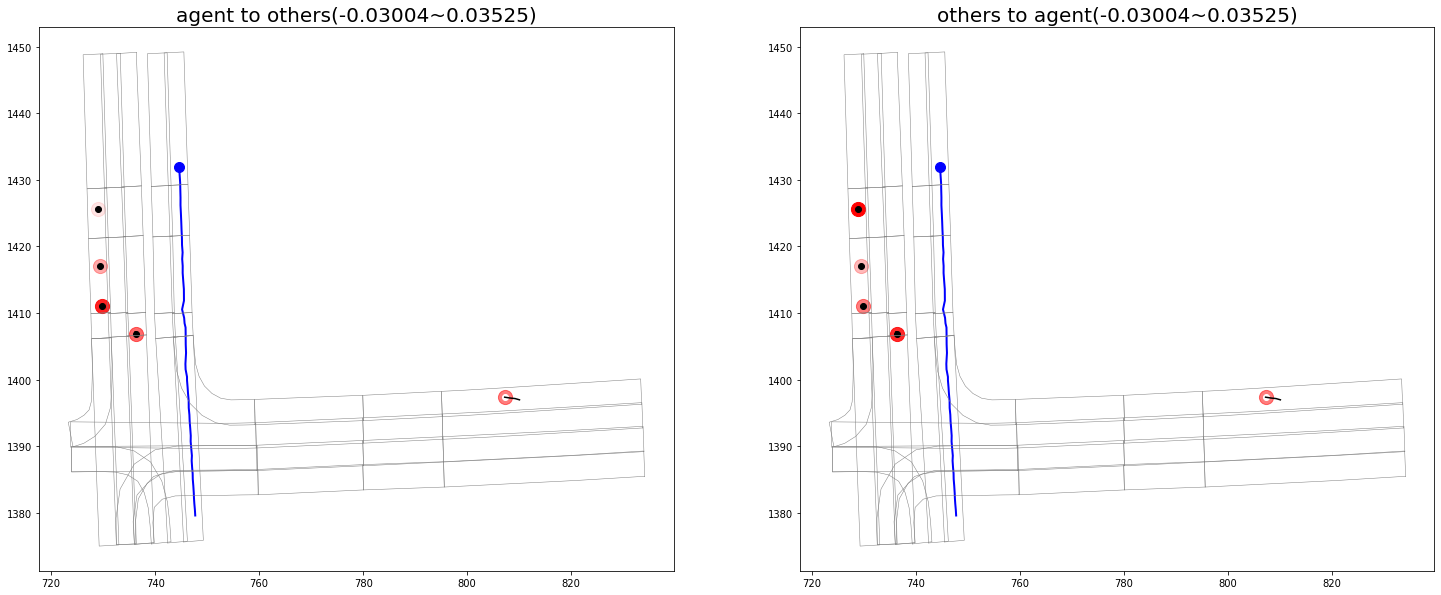

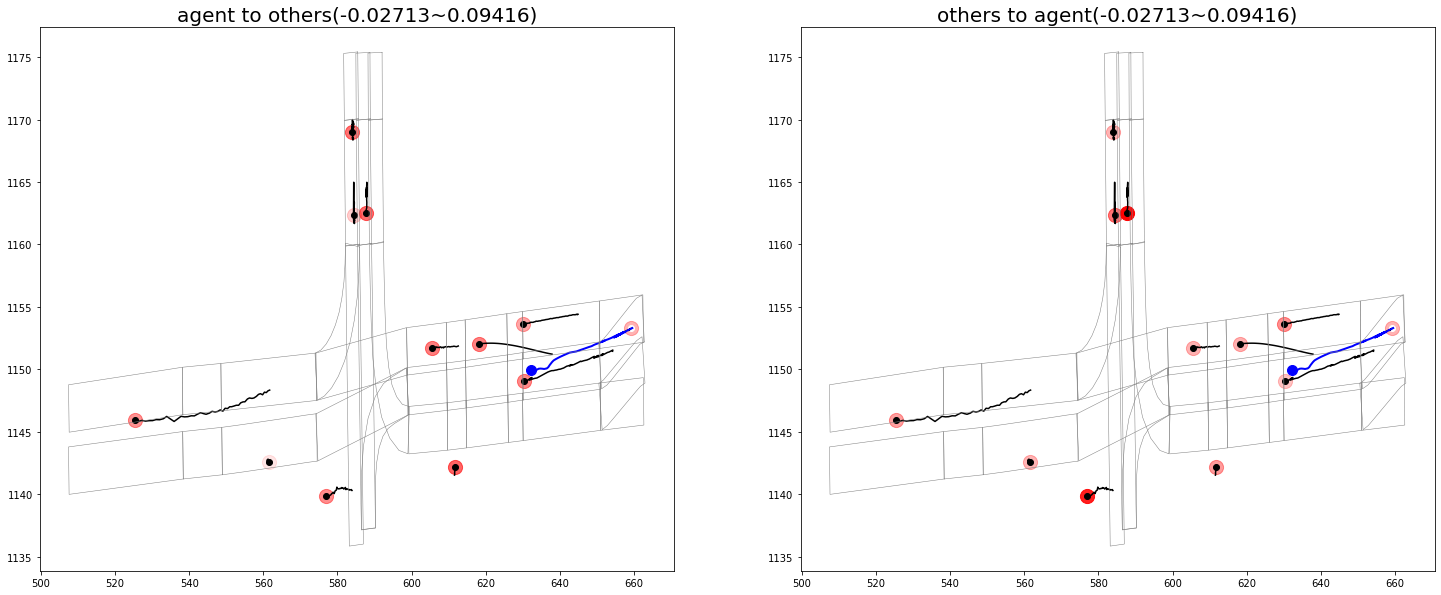

In [25]:
import os
import pickle
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm


TE_root = "TE/TEdata/val/"   # TE file
pkl_file_root = "data/argoverse_processed/val/" # pkl file
savefig = False


file_list = sorted(os.listdir(TE_root), key = lambda a: int(a.split('.')[0]))
file_list[:5]

normalize = True


for f in tqdm(file_list[1:5]):
    with open(TE_root+ f, 'rb') as pk_file:
        TEdata_more = pickle.load(pk_file)
    with open(pkl_file_root + f, 'rb') as pk_file:
        data = pickle.load(pk_file)
        

    TE_OtoA, TE_AtoO, min_arr, max_arr = normalize_TE(TEdata_more) # TE를 0과 1 사이의 값으로 만들어줌

    
    if 'LABELS' in data['AGENT'].keys():
        agent = np.concatenate((data['AGENT']['XY_FEATURES'],data['AGENT']['LABELS']), axis=0)
    else:
        agent = data['AGENT']['XY_FEATURES']
    
                 
    others = [np.concatenate((d['XY_FEATURES'], d["LABELS"])) if len(d["LABELS"]) > 1 else d['XY_FEATURES'] for d in data['SOCIAL']]
    translation_x, translation_y = data['TRANSLATION']
    city_name = data['CITY_NAME']
    rotation = data["ROTATION"]
    
    plt.figure(figsize=(25, 10))
    
    plt.subplot(121)
    plt.title(f"agent to others({min_arr}~{max_arr})", fontsize=20)
    agent_to_others = draw(agent,others,rotation,translation_x, translation_y, city_name,TE_AtoO,plt)
    
    plt.subplot(122)
    plt.title(f"others to agent({min_arr}~{max_arr})",fontsize = 20)
    others_to_agent = draw(agent,others,rotation,translation_x, translation_y, city_name,TE_OtoA,plt)
    if savefig:
        plt.savefig("ResultImg/" + f.split('.')[0] + '.png')



### make gif file

In [27]:
import os
import pickle
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm
import imageio
from PIL import Image
import matplotlib.image as mpimg
# from celluloid import Camera

TE_root = "TE/TEdata/val/"
save_path = "GIF/ResultsGIF/"
pkl_file_root = "data/argoverse_processed/val/"

file_list = sorted(os.listdir(TE_root), key = lambda a: int(a.split('.')[0]))

normalize = True
# def draw(agent,others,rotation,translation_x, translation_y, city_name):

os.makedirs(save_path, exist_ok = True)
os.makedirs("GIF/GIF_temp", exist_ok = True)
for f in tqdm(file_list[:50]):
    with open(TE_root + f, 'rb') as pk_file:
        TEdata = pickle.load(pk_file)
    
    with open(pkl_file_root + f, 'rb') as pk_file:
        data = pickle.load(pk_file)
    TE_OtoA, TE_AtoO, min_arr, max_arr = normalize_TE(TEdata)
    agent = np.concatenate((data['AGENT']['XY_FEATURES'],data['AGENT']['LABELS']), axis=0)
    others = [np.concatenate((d['XY_FEATURES'], d["LABELS"])) if len(d["LABELS"]) > 1 else d['XY_FEATURES'] for d in data['SOCIAL']]
    
    
    translation_x, translation_y = data['TRANSLATION']
    city_name = data['CITY_NAME']
    rotation = data["ROTATION"]
    
    for i in range(1,len(agent)):
        plt.figure(figsize=(25, 10))

        plt.subplot(121)
        plt.title(f"agent to others({min_arr}~{max_arr})", fontsize=20)
        agent_to_others = draw(agent,others,rotation,translation_x, translation_y, city_name,TE_AtoO,plt,i)

        plt.subplot(122)
        plt.title(f"others to agent({min_arr}~{max_arr})",fontsize = 20)
        others_to_agent = draw(agent,others,rotation,translation_x, translation_y, city_name,TE_OtoA,plt,i)
        plt.savefig("GIF/GIF_temp/" + str(i).zfill(3) + '.png')
        plt.close()
    file_name = f.split('.')[0]
    
    path = [f"./GIF/GIF_temp/{i}" for i in sorted(os.listdir("./GIF_temp"))]
    paths = [ Image.open(i) for i in path]
    imageio.mimsave(f'{save_path}/{file_name}.gif', paths, fps=10)#     print("=" * 100)




FileNotFoundError: [Errno 2] No such file or directory: './GIF_temp'